# Analise de aluguel de imoveis S√£o Paulo


## Importando Libs


In [2]:
import pandas as pd
import time
import numpy as np
import joblib
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

## Carregamento dos Dataset


In [3]:
df = pd.read_csv('/home/fbotero/Downloads/imoveis/dados/data.csv')
df.head()

address      district  area  bedrooms  garage  \
0          Rua Herval    Belenzinho    21         1       0   
1  Avenida S√£o Miguel  Vila Marieta    15         1       1   
2    Rua Oscar Freire     Pinheiros    18         1       0   
3    Rua J√∫lio Sayago       Vila R√©    56         2       2   
4  Rua Barata Ribeiro    Bela Vista    19         1       0   

                 type  rent  total  
0     Studio e kitnet  2400   2939  
1     Studio e kitnet  1030   1345  
2         Apartamento  4000   4661  
3  Casa em condom√≠nio  1750   1954  
4     Studio e kitnet  4000   4654

## Analise de Dados


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [5]:
df.describe()

area      bedrooms        garage          rent         total
count  11657.000000  11657.000000  11657.000000  11657.000000  11657.000000
mean      84.655658      1.966286      1.060393   3250.814789   4080.030625
std       74.020536      0.931313      1.132349   2650.711557   3352.480274
min        0.000000      0.000000      0.000000    500.000000    509.000000
25%       40.000000      1.000000      0.000000   1590.000000   1996.000000
50%       60.000000      2.000000      1.000000   2415.000000   3057.000000
75%       96.000000      3.000000      2.000000   3800.000000   4774.000000
max      580.000000      6.000000      6.000000  25000.000000  28700.000000

In [6]:
df.isnull().sum()

address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64

## Visualiza√ß√£o de Dados


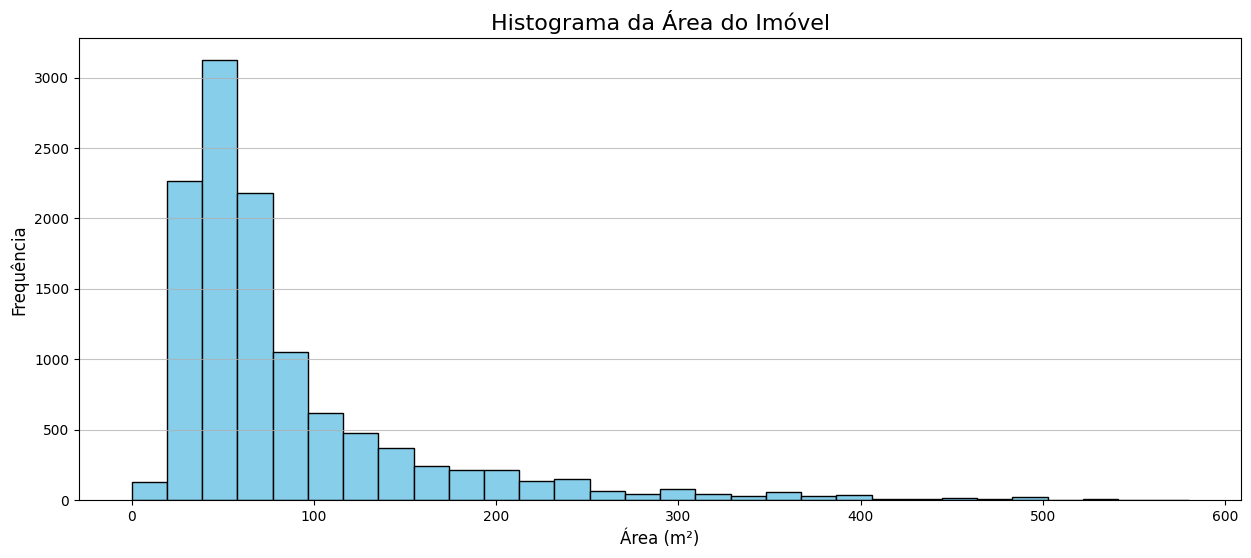

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(df.area, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Histograma da √Årea do Im√≥vel', fontsize=16)
ax.set_xlabel('√Årea (m¬≤)', fontsize=12)
ax.set_ylabel('Frequ√™ncia', fontsize=12)
ax.grid(axis='y', alpha=0.75)

count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

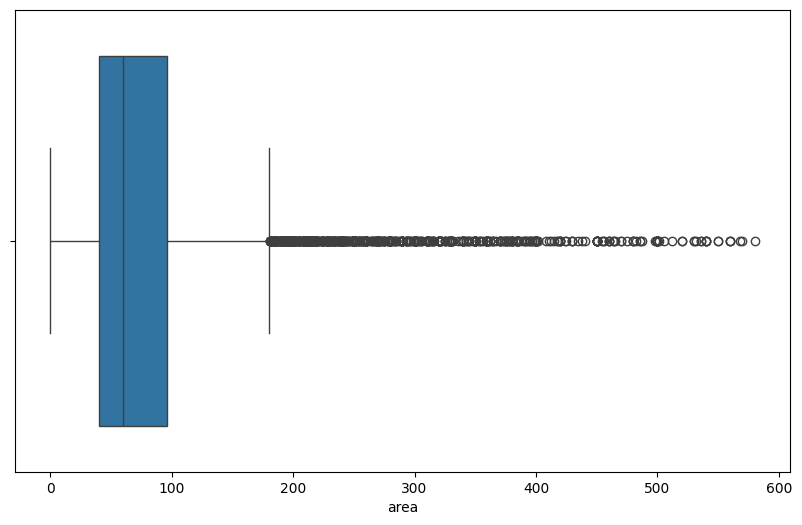

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Correla√ß√£o entre os dados

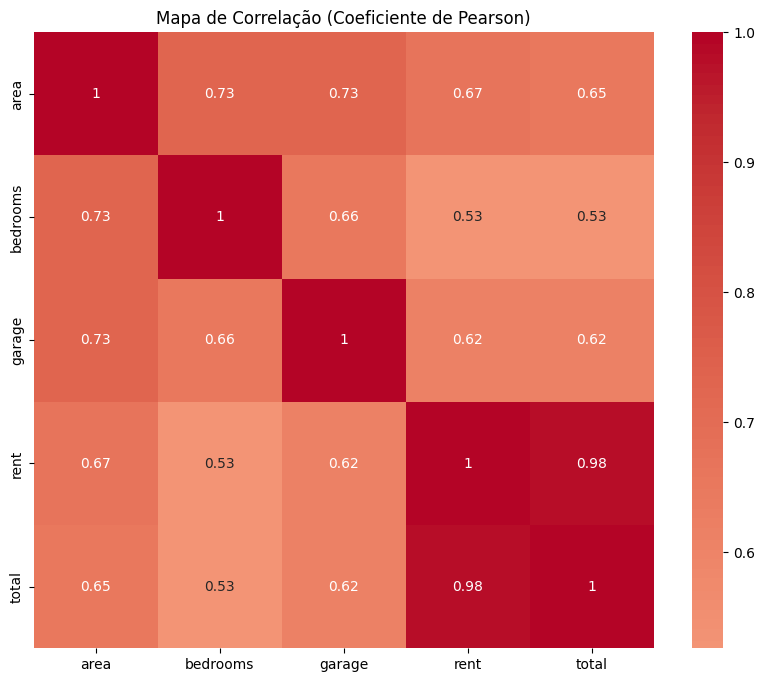

In [12]:
numeric_cols = df.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correla√ß√£o (Coeficiente de Pearson)")
plt.show()

#### Area com menor valor de aluguel


In [9]:
df[df.rent == 500]

address                  district  area  \
51                  Rua Tanque Velho                 Vila Nivi    45   
1188           Viela Renaldo Laporta  Vila Aurora (zona Norte)    30   
4741   Rua Manoel Oliveira Gon√ßalves             Jardim Ja√ßan√£    30   
5901       Rua Manuel Jos√© Rodrigues                    Sacoma    40   
6428            Rua Eug√™nia S Vitale                    Tabo√£o    30   
7420       Rua Manuel Jos√© Rodrigues                    Sacoma    20   
10559  Rua Arraial de S√£o Bartolomeu            Vila Carmosina    70   

       bedrooms  garage             type  rent  total  
51            1       0             Casa   500    551  
1188          1       0             Casa   500    521  
4741          1       0             Casa   500    509  
5901          1       0             Casa   500    521  
6428          1       0  Studio e kitnet   500    594  
7420          1       0             Casa   500    521  
10559         2       0             Casa   500    821

## Limpeza de Dados


In [9]:
# Normaliza os nomes dos bairros para padroniza√ß√£o
df['district'] = df['district'].str.lower().str.strip()
# Mapeamento manual de varia√ß√µes para nomes oficiais.
# Adicione mais mapeamentos aqui conforme necess√°rio.
mapeamento_nomes = {
    'vila aricanduva': 'Aricanduva',
    'jardim aricanduva': 'Aricanduva',
    'agua branca': '√Ågua Branca',
    'agua fria': '√Ågua Fria',
    'agua rasa': '√Ågua Rasa',
    'bras': 'Br√°s',
    'santa cecilia': 'Santa Cec√≠lia',
    'santa ifigenia': 'Santa Efig√™nia',
    'chacara santo antonio (zona sul)': 'Ch√°cara Santo Ant√¥nio',
    'chacara santo antonio (zona leste)': 'Ch√°cara Santo Ant√¥nio',
    'jardim santa cruz (campo grande)': 'Campo Grande',
    'jardim sao paulo(zona norte)': 'Jardim S√£o Paulo',
    'parque s√£o lucas': 'S√£o Lucas',
    'parque da vila prudente': 'Vila Prudente',
    'vila sonia': 'Vila S√¥nia',
    'bosque da saude': 'Sa√∫de',
    'vila da saude': 'Sa√∫de',
    'jardim da saude': 'Sa√∫de',
    'parque jabaquara': 'Jabaquara',
    'vila parque jabaquara': 'Jabaquara',
    'jardim jabaquara': 'Jabaquara',
    'jardim analia franco': 'Jardim An√°lia Franco',
    'vila pomp√©ia': 'Pomp√©ia',
    'varzea da barra funda': 'Barra Funda',
    'lapa de baixo': 'Lapa',
    'parque da lapa': 'Lapa',
    'parque residencial da lapa': 'Lapa',
    'jardim das perdizes': 'Perdizes',
    'saco ma': 'Sacom√£',
    'jardim vergueiro (sacom√£)': 'Sacdf[df.rent == 500]om√£',
    'jardim santa cruz (sacom√£)': 'Sacom√£',
    'vila matiilde': 'Vila Matilde',
    'centro capital': 'Centro',
    'vila brasilandia': 'Brasil√¢ndia',
    'vila pirituba': 'Pirituba',
    'jardim cidade pirituba': 'Pirituba',
    'jardim pirituba': 'Pirituba',
    'republica': 'Rep√∫blica',
    'jardim rio pequeno': 'Rio Pequeno',
    'parque da mooca': 'Mooca',
    'vila butanta': 'Butant√£',
    'conjunto residencial butant√£': 'Butant√£',
    'vila brasilandia': 'Brasil√¢ndia',
    'vila butanta': 'Butant√£',
    'conjunto residencial butant√£': 'Butant√£',
    'nossa senhora do √≥': 'Freguesia do √ì',
    'nossa senhora do o': 'Freguesia do √ì',
    'penha de fran√ßa': 'Penha',
    'jardim penha': 'Penha',
    'jardim america da penha': 'Penha',
    'jardim paulistano': 'Jardim Paulista',
    'jardim peri peri': 'Jardim Peri',
    'vila s√£o jos√© (ipiranga)': 'Ipiranga',
    'vila maria alta': 'Vila Maria',
    'vila maria baixa': 'Vila Maria',
    'jardim vila mariana': 'Vila Mariana',
    'panamby': 'Panamby',
    'super quadra morumbi': 'Morumbi',
    'recanto morumbi': 'Morumbi',
    'jardim parque morumbi': 'Morumbi',
    'parque bairro morumbi': 'Morumbi',
    'jardim independencia (s√£o paulo)': 'Jardim Independ√™ncia',
    'jardim panaroma (zona leste)': 'Jardim Am√©rica',
    'brooklin novo': 'Brooklin',
    'brooklin paulista': 'Brooklin',
}

# Aplica o mapeamento para criar a coluna de bairro oficial
df['district'] = df['district'].apply(
    lambda x: mapeamento_nomes.get(x, x.title())
)

### Tratando os outliers


Consideramos im√≥veis entre 40m¬≤ e 90m¬≤, pois refletem o padr√£o de apartamentos destinados √†
classe m√©dia, segundo dados do mercado imobili√°rio.‚Äù


In [10]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 90]
df.describe()

address     Rua Manuel Jos√© Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


area     bedrooms       garage          rent         total
count  8276.000000  8276.000000  8276.000000   8276.000000   8276.000000
mean     50.707347     1.592073     0.639439   2313.761479   2932.239004
std      17.067264     0.644834     0.644764   1393.406429   1723.223935
min      20.000000     0.000000     0.000000    500.000000    509.000000
25%      37.000000     1.000000     0.000000   1400.000000   1747.000000
50%      50.000000     2.000000     1.000000   2000.000000   2543.000000
75%      64.000000     2.000000     1.000000   2810.000000   3652.250000
max      89.000000     4.000000     5.000000  25000.000000  26710.000000

<Axes: xlabel='area'>

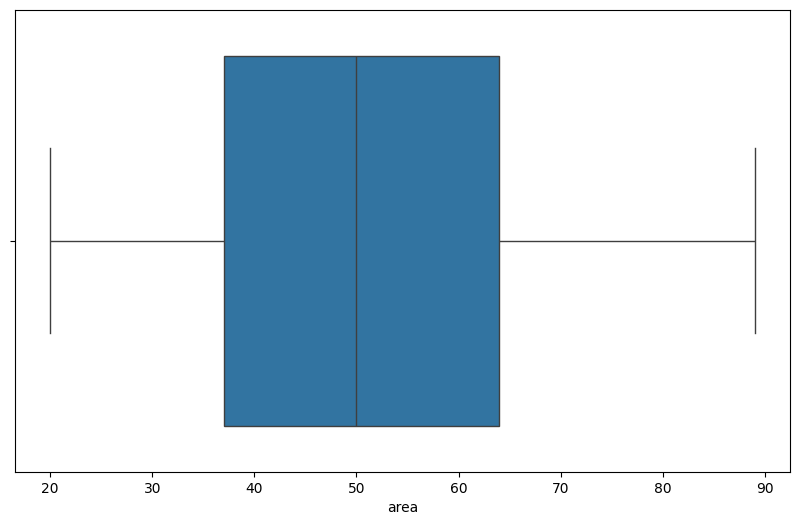

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])

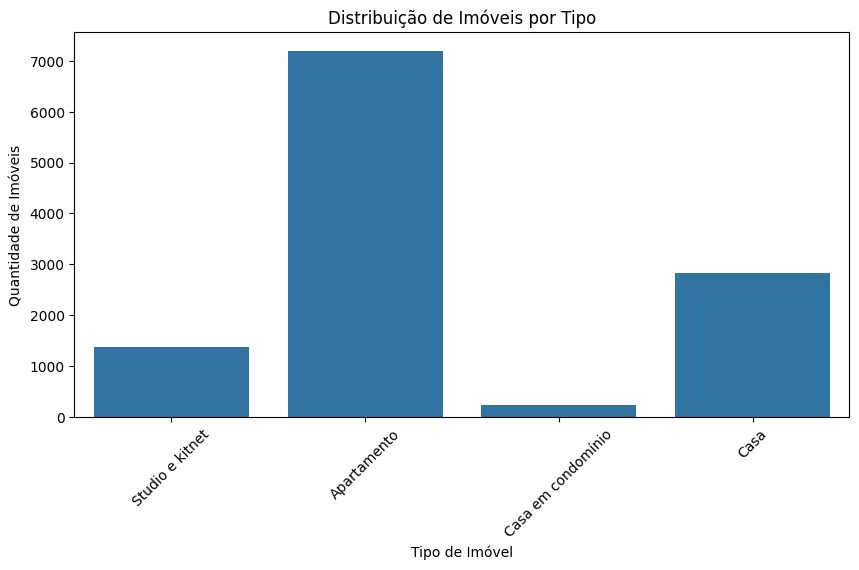

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='type')
plt.title('Distribui√ß√£o de Im√≥veis por Tipo')
plt.xticks(rotation=45)
plt.ylabel('Quantidade de Im√≥veis')
plt.xlabel('Tipo de Im√≥vel')
plt.show()

#### Removendo imoveis sem quartos


In [12]:
df = df[df.bedrooms >= 1]
df.describe()

area     bedrooms       garage          rent         total
count  8245.000000  8245.000000  8245.000000   8245.000000   8245.000000
mean     50.769436     1.598059     0.641601   2316.470467   2935.720558
std      17.055005     0.638598     0.644833   1394.657523   1724.806960
min      20.000000     1.000000     0.000000    500.000000    509.000000
25%      37.000000     1.000000     0.000000   1400.000000   1750.000000
50%      50.000000     2.000000     1.000000   2000.000000   2545.000000
75%      64.000000     2.000000     1.000000   2820.000000   3657.000000
max      89.000000     4.000000     5.000000  25000.000000  26710.000000

## Engenharia de Features


#### Removendo features que n√£o ser√£o utilizadas


In [13]:
df_clean = df.drop(columns=['rent','address'])

#### Criando coluna "price_m2"


In [14]:
df_clean["price_m2"] = df_clean["total"] / df_clean["area"]
df_clean.price_m2.describe()

count    8245.000000
mean       61.374726
std        37.250008
min         9.650000
25%        37.628571
50%        51.500000
75%        74.543210
max      1112.916667
Name: price_m2, dtype: float64

#### Criando coluna "price_level"


Foi utilizado dados a partir de uma pesquisa de mercado para entender os valores do m2 de alguel em SP, assim substituimos so valores dos quartis na nossa analise para os encotrados


In [15]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df_clean["price_level"] = pd.cut(
    df_clean["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

#### Distribui√ß√£o de Imoveis Pre√ßo Total


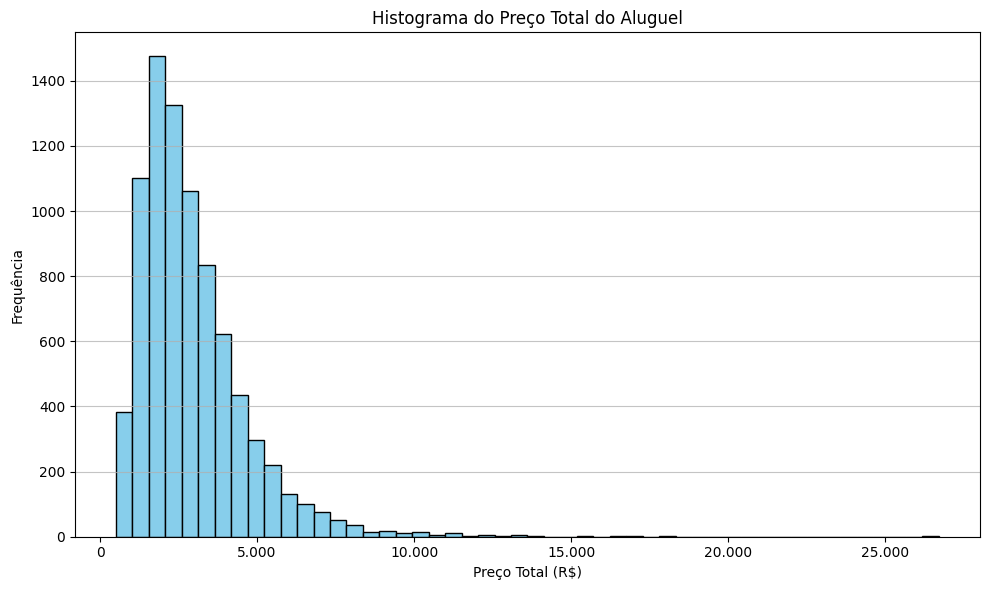

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['total'], bins=50, color='skyblue', edgecolor='black')

ax.set_title('Histograma do Pre√ßo Total do Aluguel')
ax.set_xlabel('Pre√ßo Total (R$)')
ax.set_ylabel('Frequ√™ncia')
ax.grid(axis='y', alpha=0.75)

ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(",", "."))
)

plt.tight_layout()

#### Distribui√ß√£o de Imoveis Pre√ßo m2


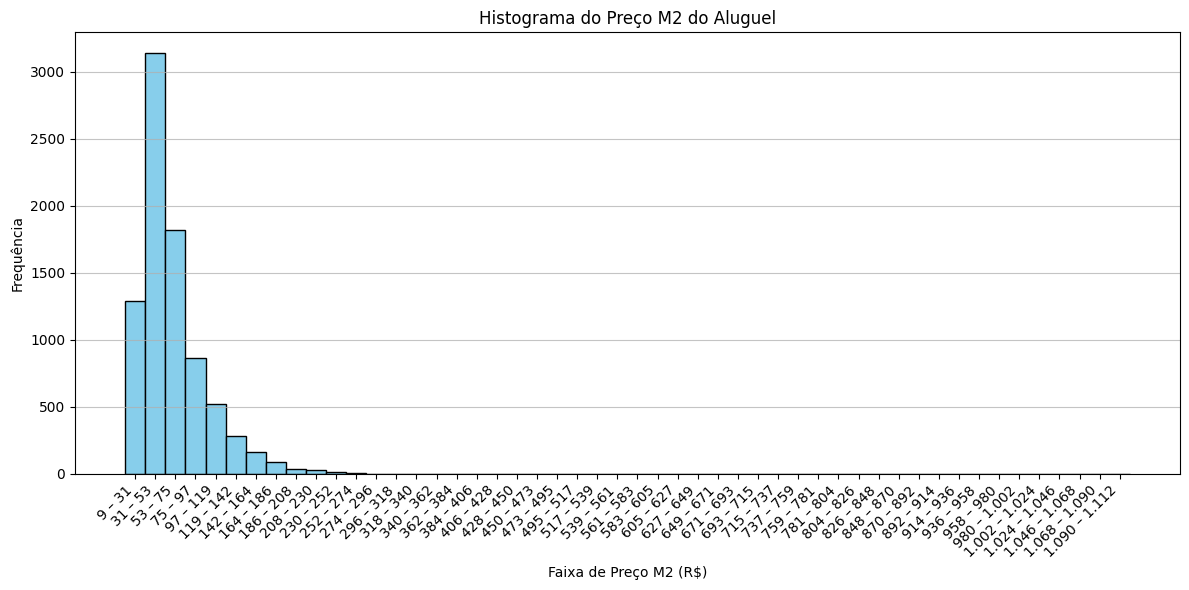

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

counts, bins, patches = ax.hist(
    df_clean['price_m2'], bins=50, color='skyblue', edgecolor='black'
)

bin_labels = [f"{int(bins[i]):,} ‚Äì {int(bins[i+1]):,}".replace(",", ".")
              for i in range(len(bins)-1)]

bin_centers = (bins[:-1] + bins[1:]) / 2
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=45, ha="right")

ax.set_title("Histograma do Pre√ßo M2 do Aluguel")
ax.set_xlabel("Faixa de Pre√ßo M2 (R$)")
ax.set_ylabel("Frequ√™ncia")
ax.grid(axis="y", alpha=0.75)

plt.tight_layout()
plt.show()


#### Mapear bairros para cada faixa


In [18]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "M√©dio", "Alto", "Muito Alto"]

df_clean["faixa_preco_m2"] = pd.cut(df_clean["price_m2"], bins=bins, labels=labels, include_lowest=True)

# Contagem de im√≥veis por distrito dentro de cada faixa
concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")

# Para cada faixa, pegar o distrito com maior concentra√ß√£o
top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]

top_distritos


/tmp/ipykernel_79423/2679612559.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")
/tmp/ipykernel_79423/2679612559.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]


faixa_preco_m2      district  quantidade
17            Baixo    Bela Vista          88
1003          M√©dio    Bela Vista          78
1989           Alto    Bela Vista          61
3770     Muito Alto  Vila Mariana          92

#### Distribui√ß√£o Bairro e N√≠vel de Pre√ßo


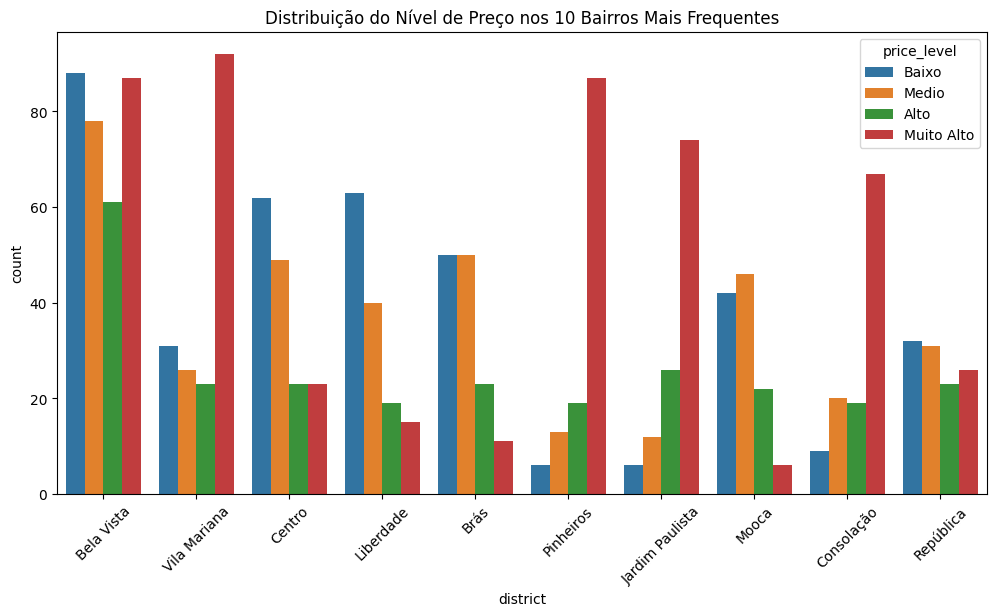

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='district', hue='price_level', order=df_clean['district'].value_counts().iloc[:10].index)
plt.title('Distribui√ß√£o do N√≠vel de Pre√ßo nos 10 Bairros Mais Frequentes')
plt.xticks(rotation=45)
plt.show()

#### Distribui√ß√£o Tipo de Im√≥vel e N√≠vel de Pre√ßo


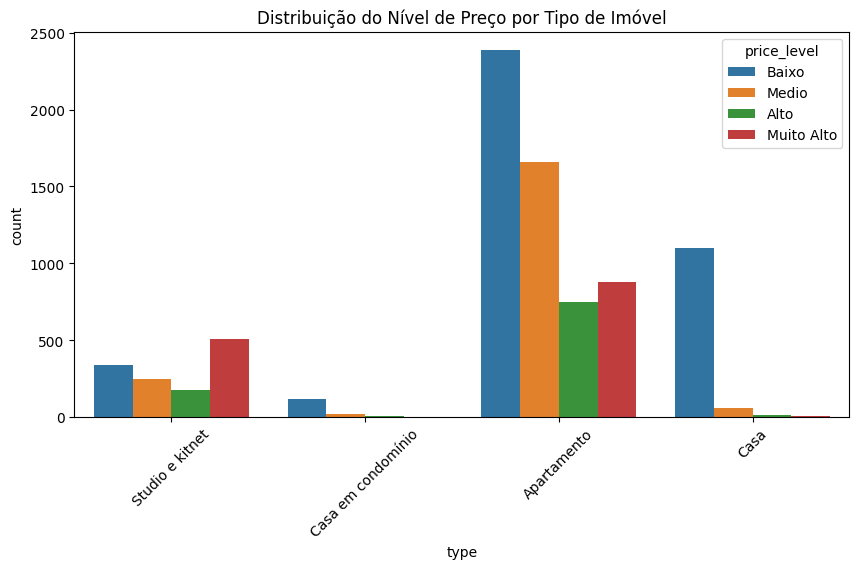

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='type', hue='price_level')
plt.title('Distribui√ß√£o do N√≠vel de Pre√ßo por Tipo de Im√≥vel')
plt.xticks(rotation=45)
plt.show()

### Correla√ß√£o de Pearson


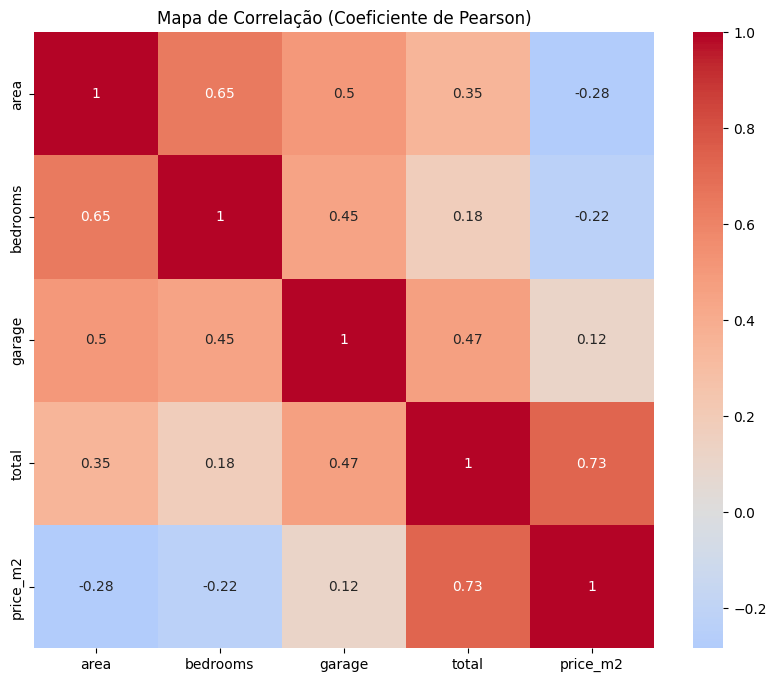

In [21]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correla√ß√£o (Coeficiente de Pearson)")
plt.show()


#### Removendo linhas com NaN na feature target


In [22]:
df_clean.replace("?", np.nan, inplace=True)
df_clean = df_clean.dropna(subset=["price_level"])
df_clean

district  area  bedrooms  garage                type  \
0                   Belenzinho    21         1       0     Studio e kitnet   
3                      Vila R√©    56         2       2  Casa em condom√≠nio   
5                         Br√°s    50         2       1         Apartamento   
6                     Brooklin    72         2       1         Apartamento   
7                       Centro    26         1       0     Studio e kitnet   
...                        ...   ...       ...     ...                 ...   
11638              Santo Amaro    70         2       1         Apartamento   
11640         Jardim Caravelas    78         2       1         Apartamento   
11645              Santo Amaro    70         2       0         Apartamento   
11654         Jardim Caravelas    84         1       2         Apartamento   
11655  Jardim Fonte Do Morumbi    76         1       0         Apartamento   

       total    price_m2 price_level faixa_preco_m2  
0       2939  139.952381  Muito Alto     Muito Alto  
3       1954   34.892857       Baixo          Baixo  
5       4587   91.740000  Muito Alto     Muito Alto  
6       5187   72.041667        Alto           Alto  
7       2244   86.307692        Alto           Alto  
...      ...         ...         ...            ...  
11638   4215   60.214286       Medio          M√©dio  
11640   3686   47.256410       Baixo          Baixo  
11645   3116   44.514286       Baixo          Baixo  
11654   5467   65.083333       Medio          M√©dio  
11655  10200  134.210526  Muito Alto     Muito Alto  

[8245 rows x 9 columns]

#### Distribui√ß√£o Imoveis por Price_level


price_level
Baixo         3936
Medio         1981
Muito Alto    1390
Alto           938
Name: count, dtype: int64


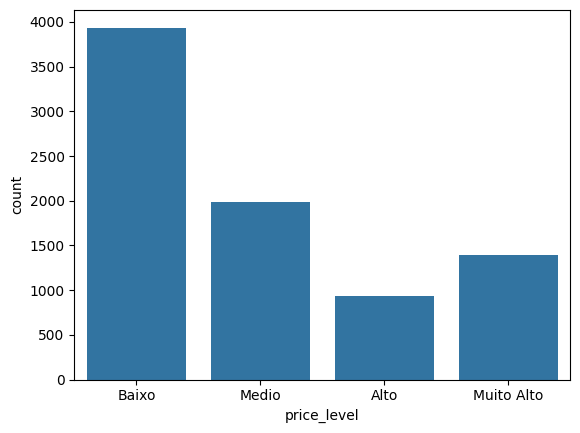

In [23]:
sns.countplot(x = df_clean['price_level'])
print(df_clean["price_level"].value_counts())

## Separa√ß√£o de Dados e Treinamento


#### Divis√£o entre previsores (X) e classe (y)


In [24]:
target = "price_level"
X = df_clean.drop(columns=[target, 'price_m2', 'total','faixa_preco_m2'])
y = df_clean[target]

print("Features utilizadas para o treinamento:", X.columns.tolist())

Features utilizadas para o treinamento: ['district', 'area', 'bedrooms', 'garage', 'type']


#### Separando variaveis entre numericas e categoricas


In [25]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

#### Escalonamento dos valores e Codifica√ß√£o de vari√°veis categ√≥ricas


In [26]:
ohe_enc = OneHotEncoder(sparse_output=False)
scaler_std = StandardScaler()

X_num_std = scaler_std.fit_transform(df[num_features])
X_nom = ohe_enc.fit_transform(df[cat_features]) if cat_features else np.empty((len(df),0))

X_final = np.hstack([X_num_std, X_nom])
X_final

array([[-1.74560142, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30670651,  0.62944868,  2.10671926, ...,  0.        ,
         1.        ,  0.        ],
       [-0.0451177 ,  0.62944868,  0.5558353 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12762969,  0.62944868, -0.99504865, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94855286, -0.93657557,  2.10671926, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47945391, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  0.        ]], shape=(8245, 993))

#### Divis√£o da Base em treinamento, teste


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

#### Transformer para converter sparse -> dense (para Naive Bayes)


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X_final, y=None):
        return self
    def transform(self, X_final, y=None):
        return X_final.toarray()

#### Configurando modelos


In [29]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "NaiveBayes": GaussianNB()
}

#### Configurando Parametros

In [30]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    }
}

In [31]:
resultados = []

#### Configurando treinamento

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

resultados_global = [] 

def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Vari√°veis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necess√°rio
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necess√°rio
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in models_default.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'N√£o'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medi√ß√£o de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previs√µes
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"‚ú® Novo melhor modelo encontrado: {descricao_cenario} com acur√°cia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes din√¢micas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confus√£o
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predi√ß√£o')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confus√£o - {descricao_cenario}')
        plt.show()

        # Relat√≥rio de classifica√ß√£o
        print(f"\nRelat√≥rio de Classifica√ß√£o para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"üìå Melhores par√¢metros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acur√°cia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Par√¢metros": best_params
            })

            # Salvar par√¢metros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'/home/fbotero/Downloads/imoveis/dados/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acur√°cia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Par√¢metros": "N/A"
            })

        print("=" * 52)

    # Compara√ß√£o final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acur√°cia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'/home/fbotero/Downloads/imoveis/dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"‚ú® Melhor modelo salvo: {nome_melhor_modelo} com acur√°cia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline


Cenarios

In [44]:
df_resultados_globais = pd.DataFrame(resultados_global)
df_resultados_globais.head()

Modelo  Acur√°cia Teste  \
0  LogisticRegression | Balanceamento: Nenhum | P...        0.653123   
1  RandomForest | Balanceamento: Nenhum | PCA: N√£...        0.614312   
2  SVM | Balanceamento: Nenhum | PCA: N√£o | Param...        0.642207   
3  KNN | Balanceamento: Nenhum | PCA: N√£o | Param...        0.591874   
4  DecisionTree | Balanceamento: Nenhum | PCA: N√£...        0.589448   

   Tempo Treinamento (s) Melhores Par√¢metros  
0               7.652923                 N/A  
1               4.035075                 N/A  
2              17.101359                 N/A  
3               0.006812                 N/A  
4               0.583081                 N/A

In [ ]:
import pandas as pd

# Garantir que tipo_parametros j√° est√° extra√≠do
df_resultados_globais["tipo_parametros"] = df_resultados_globais["Modelo"].str.extract(r"Parametros: (\w+)")

# Filtrar apenas os modelos com grid
df_filtrado = df_resultados_globais[df_resultados_globais["tipo_parametros"] == "grid"]

# Extrair o nome base do modelo (primeira parte antes do "|")
df_filtrado["ModeloBase"] = df_filtrado["Modelo"].str.split("|").str[0].str.strip()

# Agora, pegar o melhor por cada modelo base
melhores_por_modelo = df_filtrado.loc[
    df_filtrado.groupby("ModeloBase")["Acur√°cia Teste"].idxmax()
]

print("Melhor par√¢metro (grid) para cada modelo:")
print(melhores_por_modelo[["ModeloBase", "Acur√°cia Teste", "Melhores Par√¢metros"]])
# Selecionar apenas as colunas que voc√™ quer salvar
df_to_save = melhores_por_modelo[["ModeloBase", "Acur√°cia Teste", "Melhores Par√¢metros"]]

# Salvar em CSV
df_to_save.to_csv("melhores_modelos_grid.csv", index=False)

print("Arquivo 'melhores_modelos_grid.csv' salvo com sucesso!")

Melhor par√¢metro (grid) para cada modelo:
            ModeloBase  Acur√°cia Teste  \
39        DecisionTree        0.600364   
66                 KNN        0.612492   
35  LogisticRegression        0.651304   
62          NaiveBayes        0.558520   
61       NeuralNetwork        0.649485   
57        RandomForest        0.643420   
37                 SVM        0.642814   

                                  Melhores Par√¢metros  
39  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
66  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
35     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}  
62                                                N/A  
61  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
57  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...  
37     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}  
Arquivo 'melhores_modelos_grid.csv' salvo com sucesso!


/tmp/ipykernel_79423/3896266342.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["ModeloBase"] = df_filtrado["Modelo"].str.split("|").str[0].str.strip()


In [ ]:
best_params_dict = dict(zip(melhores_por_modelo["ModeloBase"], melhores_por_modelo["Melhores Par√¢metros"]))
print(best_params_dict)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [50]:
best_params_dict = dict(zip(melhores_por_modelo["ModeloBase"], melhores_por_modelo["Melhores Par√¢metros"]))

best_params_cleaned = {
    modelo: params if isinstance(params, dict) else {}
    for modelo, params in best_params_dict.items()
}

best_models = {
    "LogisticRegression": LogisticRegression(**best_params_cleaned.get("LogisticRegression", {})),
    "RandomForest": RandomForestClassifier(**best_params_cleaned.get("RandomForest", {})),
    "SVM": SVC(**best_params_cleaned.get("SVM", {})),
    "KNN": KNeighborsClassifier(**best_params_cleaned.get("KNN", {})),
    "DecisionTree": DecisionTreeClassifier(**best_params_cleaned.get("DecisionTree", {})),
    "NeuralNetwork": MLPClassifier(**best_params_cleaned.get("NeuralNetwork", {})),
    "NaiveBayes": GaussianNB(**best_params_cleaned.get("NaiveBayes", {})),
}


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Vari√°veis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necess√°rio
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necess√°rio
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in best_models.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'N√£o'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medi√ß√£o de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previs√µes
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"‚ú® Novo melhor modelo encontrado: {descricao_cenario} com acur√°cia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes din√¢micas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confus√£o
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predi√ß√£o')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confus√£o - {descricao_cenario}')
        plt.show()

        # Relat√≥rio de classifica√ß√£o
        print(f"\nRelat√≥rio de Classifica√ß√£o para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"üìå Melhores par√¢metros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acur√°cia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Par√¢metros": best_params
            })

            # Salvar par√¢metros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'/home/fbotero/Downloads/imoveis/dados/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acur√°cia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Par√¢metros": "N/A"
            })

        print("=" * 52)

    # Compara√ß√£o final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acur√°cia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'/home/fbotero/Downloads/imoveis/dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"‚ú® Melhor modelo salvo: {nome_melhor_modelo} com acur√°cia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline



==================== LogisticRegression ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para LogisticRegression, usando default.
‚ú® Novo melhor modelo encontrado: LogisticRegression | Balanceamento: Nenhum | PCA: N√£o | Parametros: best com acur√°cia de 0.6513!


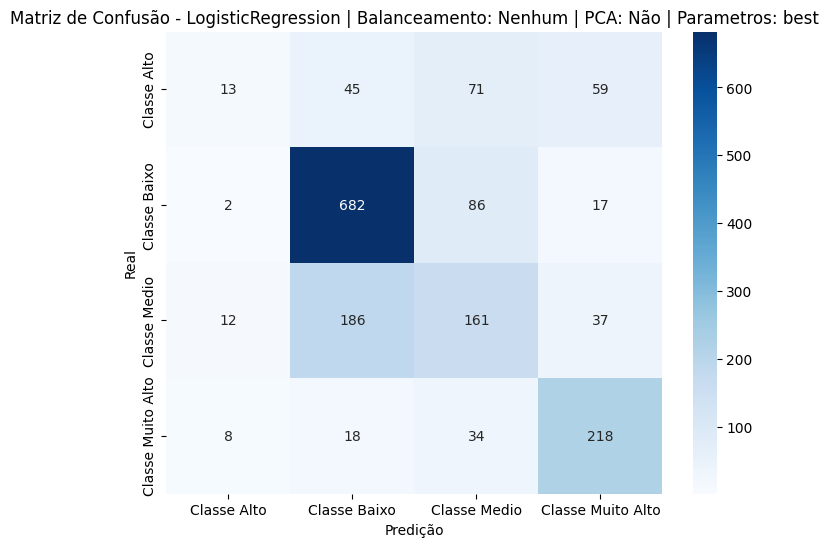


Relat√≥rio de Classifica√ß√£o para LogisticRegression | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 9.5823 segundos

==================== RandomForest ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para RandomForest, usando default.


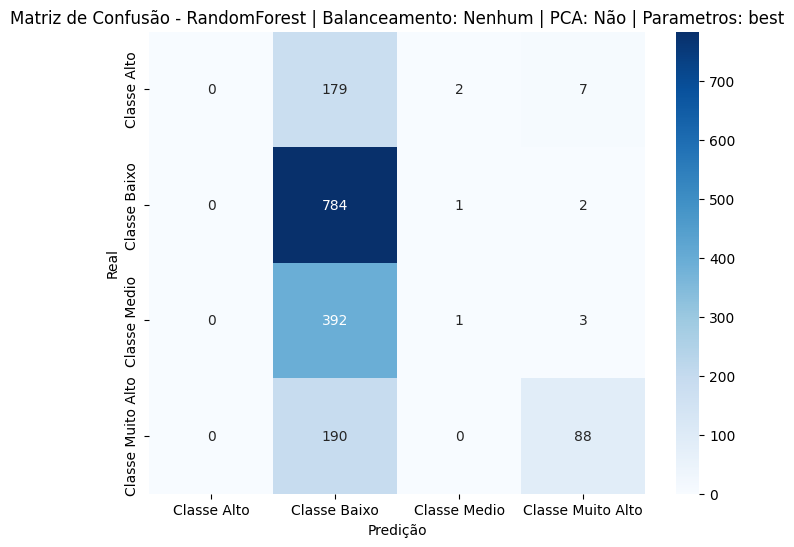


Relat√≥rio de Classifica√ß√£o para RandomForest | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.51      1.00      0.67       787
     Classe Medio       0.25      0.00      0.01       396
Classe Muito Alto       0.88      0.32      0.47       278

         accuracy                           0.53      1649
        macro avg       0.41      0.33      0.29      1649
     weighted avg       0.45      0.53      0.40      1649

Tempo de treinamento: 2.6746 segundos

==================== SVM ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para SVM, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

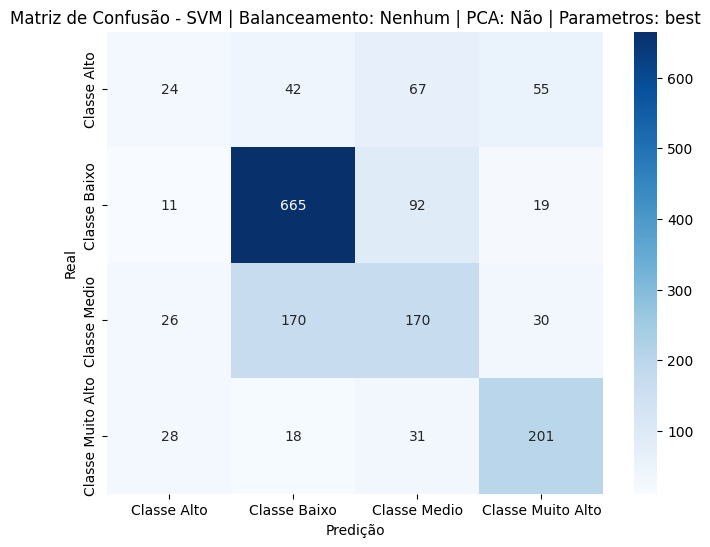


Relat√≥rio de Classifica√ß√£o para SVM | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.5038 segundos

==================== KNN ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para KNN, usando default.


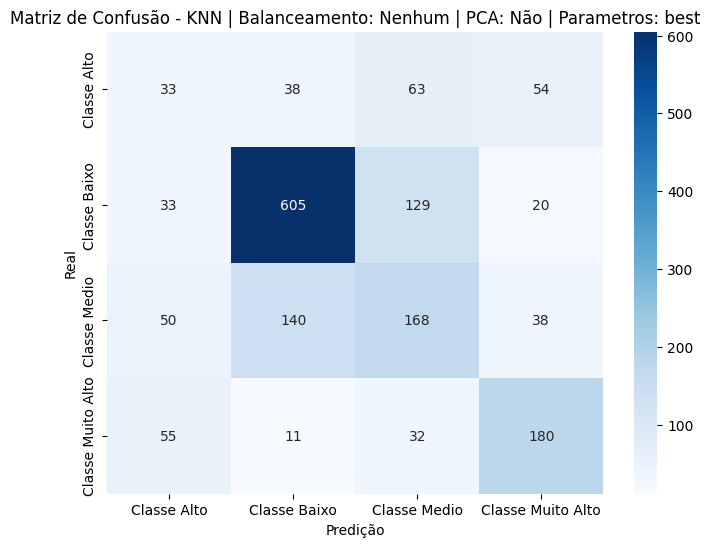


Relat√≥rio de Classifica√ß√£o para KNN | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.77       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.60      1649

Tempo de treinamento: 0.0060 segundos

==================== DecisionTree ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para DecisionTree, usando default.


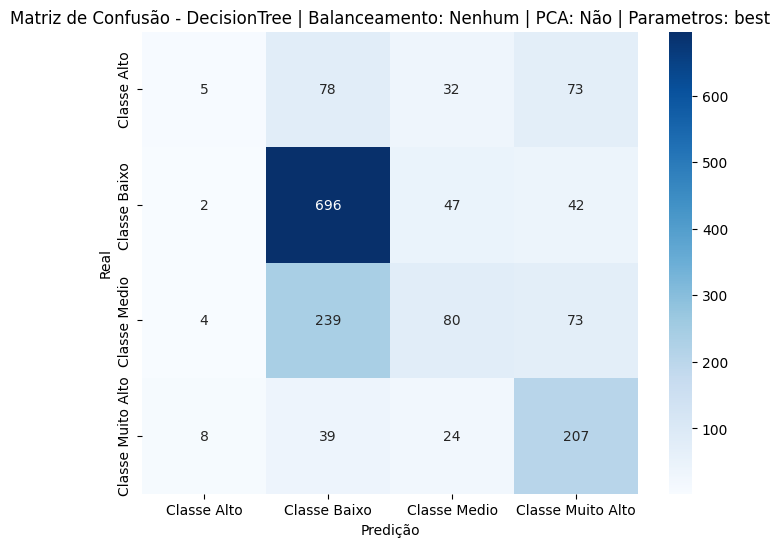


Relat√≥rio de Classifica√ß√£o para DecisionTree | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1907 segundos

==================== NeuralNetwork ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para NeuralNetwork, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


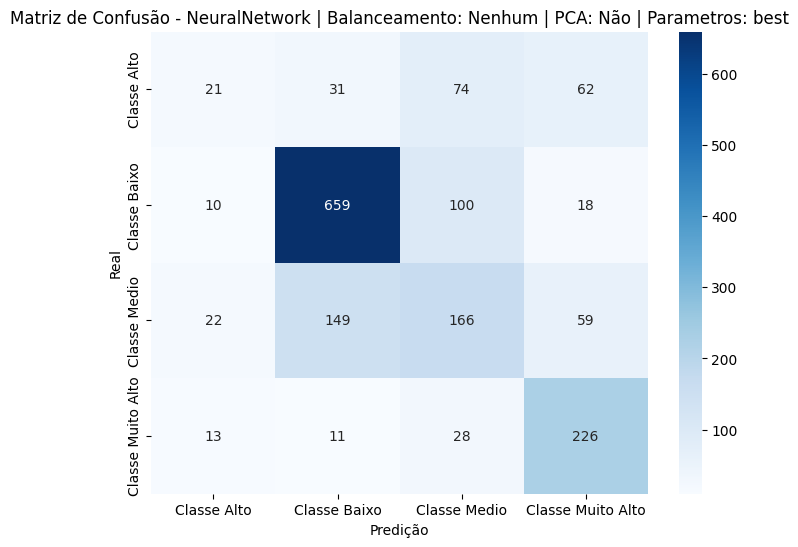


Relat√≥rio de Classifica√ß√£o para NeuralNetwork | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.32      0.11      0.17       188
     Classe Baixo       0.78      0.84      0.81       787
     Classe Medio       0.45      0.42      0.43       396
Classe Muito Alto       0.62      0.81      0.70       278

         accuracy                           0.65      1649
        macro avg       0.54      0.55      0.53      1649
     weighted avg       0.62      0.65      0.63      1649

Tempo de treinamento: 21.0128 segundos

==================== NaiveBayes ====================


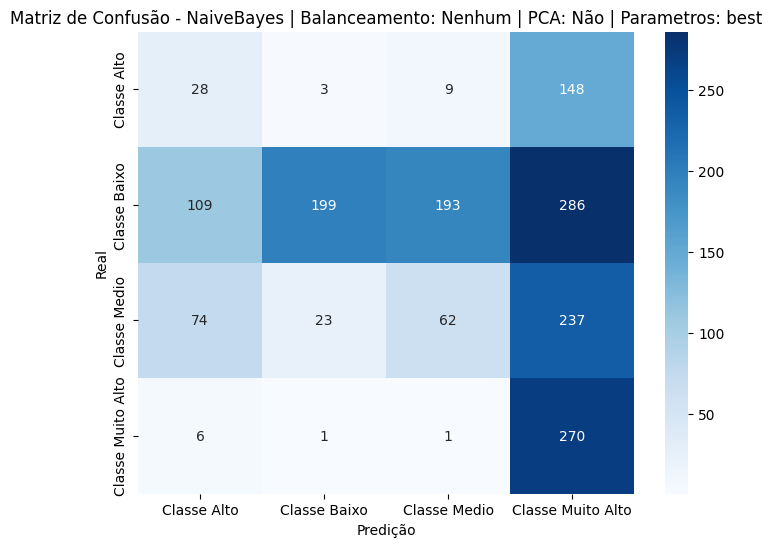


Relat√≥rio de Classifica√ß√£o para NaiveBayes | Balanceamento: Nenhum | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0617 segundos


Modelo  Acur√°cia Teste  \
0  LogisticRegression | Balanceamento: Nenhum | P...        0.651304   
5  NeuralNetwork | Balanceamento: Nenhum | PCA: N...        0.650091   
2  SVM | Balanceamento: Nenhum | PCA: N√£o | Param...        0.642814   
4  DecisionTree | Balanceamento: Nenhum | PCA: N√£...        0.599151   
3  KNN | Balanceamento: Nenhum | PCA: N√£o | Param...        0.597938   
1  RandomForest | Balanceamento: Nenhum | PCA: N√£...        0.529412   
6  NaiveBayes | Balanceamento: Nenhum | PCA: N√£o ...        0.338993   

   Tempo Treinamento (s) Melhores Par√¢metros  
0               9.582273                 N/A  
5              21.012808                 N/A  
2              14.503765                 N/A  
4               0.190709                 N/A  
3               0.005971                 N/A  
1               2.674647                 N/A  
6               0.061744                 N/A

‚ú® Melhor modelo salvo: LogisticRegression com acur√°cia de 0.6513!

==================== LogisticRegression ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para LogisticRegression, usando default.
‚ú® Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: N√£o | Parametros: best com acur√°cia de 0.6513!


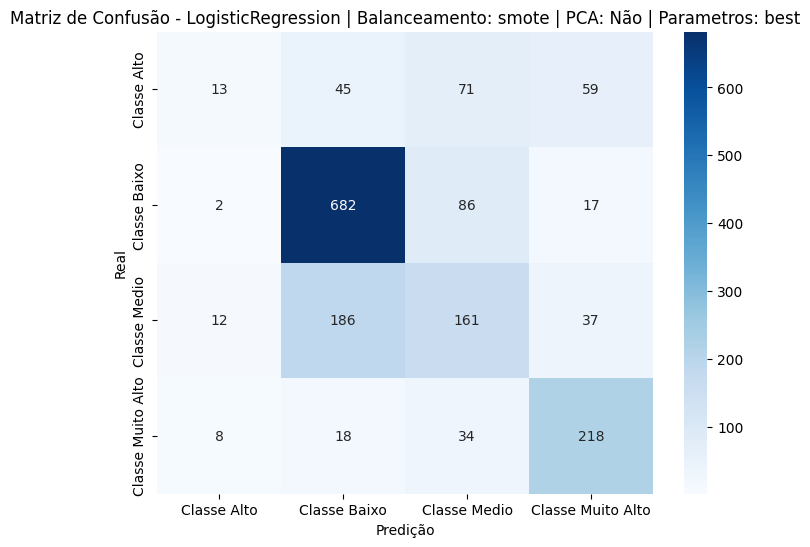


Relat√≥rio de Classifica√ß√£o para LogisticRegression | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 9.6153 segundos

==================== RandomForest ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para RandomForest, usando default.


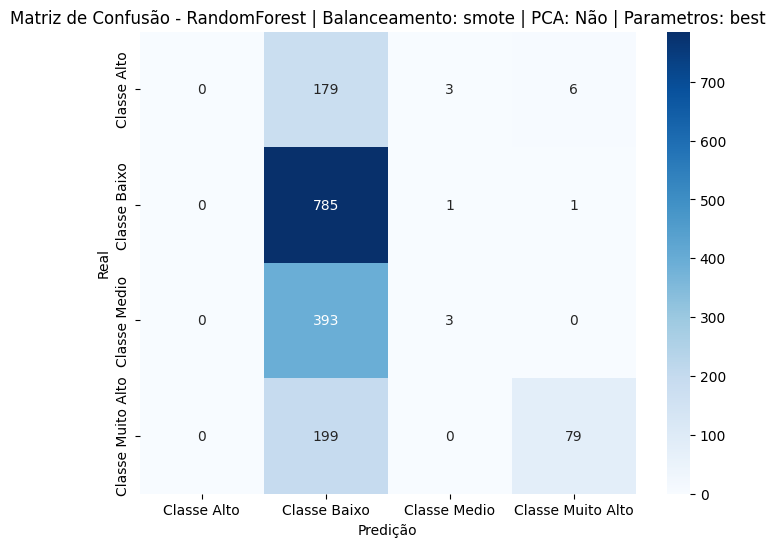


Relat√≥rio de Classifica√ß√£o para RandomForest | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.50      1.00      0.67       787
     Classe Medio       0.43      0.01      0.01       396
Classe Muito Alto       0.92      0.28      0.43       278

         accuracy                           0.53      1649
        macro avg       0.46      0.32      0.28      1649
     weighted avg       0.50      0.53      0.40      1649

Tempo de treinamento: 2.6135 segundos

==================== SVM ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para SVM, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

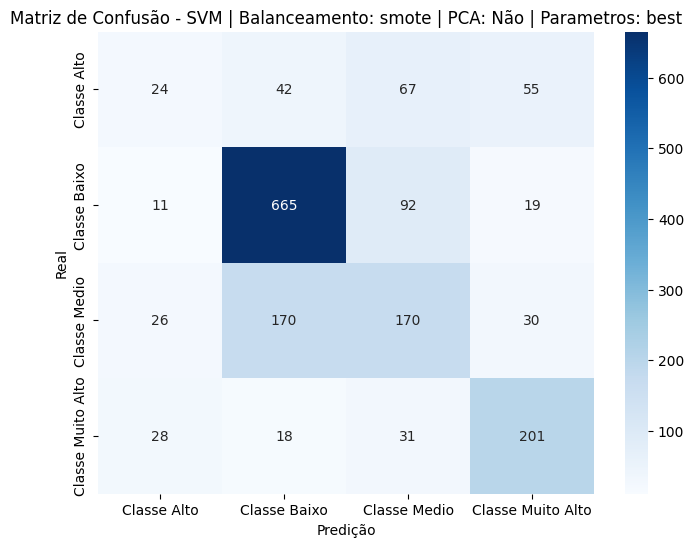


Relat√≥rio de Classifica√ß√£o para SVM | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.3607 segundos

==================== KNN ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para KNN, usando default.


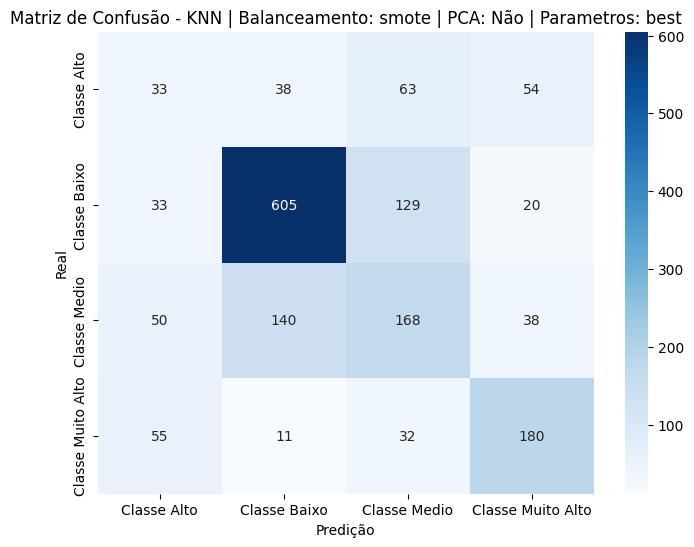


Relat√≥rio de Classifica√ß√£o para KNN | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.77       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.60      1649

Tempo de treinamento: 0.0056 segundos

==================== DecisionTree ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para DecisionTree, usando default.


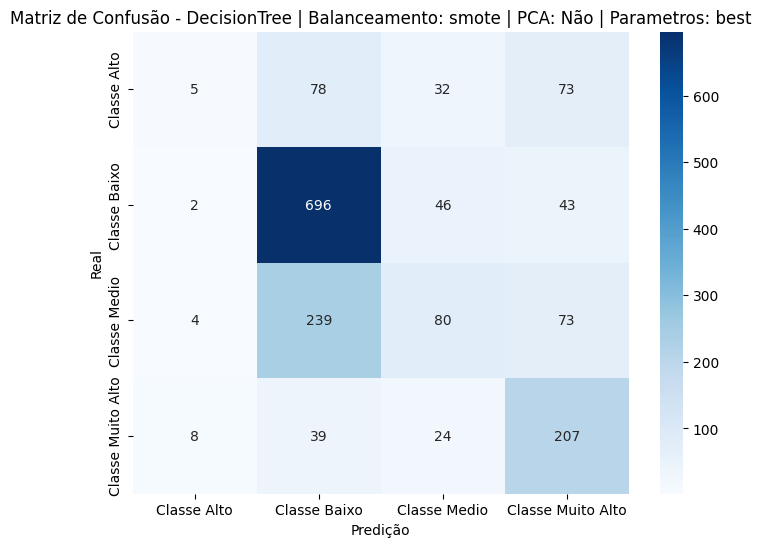


Relat√≥rio de Classifica√ß√£o para DecisionTree | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.61       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1984 segundos

==================== NeuralNetwork ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para NeuralNetwork, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Relat√≥rio de Classifica√ß√£o para NeuralNetwork | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.29      0.12      0.17       188
     Classe Baixo       0.78      0.83      0.80       787
     Classe Medio       0.47      0.42      0.45       396
Classe Muito Alto       0.59      0.81      0.68       278

         accuracy                           0.65      1649
        macro avg       0.53      0.55      0.53      1649
     weighted avg       0.62      0.65      0.63      1649

Tempo de treinamento: 20.9427 segundos

==================== NaiveBayes ====================



Relat√≥rio de Classifica√ß√£o para NaiveBayes | Balanceamento: smote | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0606 segundos


Modelo  Acur√°cia Teste  \
0  LogisticRegression | Balanceamento: smote | PC...        0.651304   
5  NeuralNetwork | Balanceamento: smote | PCA: N√£...        0.647059   
2  SVM | Balanceamento: smote | PCA: N√£o | Parame...        0.642814   
4  DecisionTree | Balanceamento: smote | PCA: N√£o...        0.599151   
3  KNN | Balanceamento: smote | PCA: N√£o | Parame...        0.597938   
1  RandomForest | Balanceamento: smote | PCA: N√£o...        0.525773   
6  NaiveBayes | Balanceamento: smote | PCA: N√£o |...        0.338993   

   Tempo Treinamento (s) Melhores Par√¢metros  
0               9.615293                 N/A  
5              20.942727                 N/A  
2              14.360680                 N/A  
4               0.198387                 N/A  
3               0.005584                 N/A  
1               2.613496                 N/A  
6               0.060639                 N/A

‚ú® Melhor modelo salvo: LogisticRegression com acur√°cia de 0.6513!

==================== LogisticRegression ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para LogisticRegression, usando default.
‚ú® Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: N√£o | Parametros: best com acur√°cia de 0.6513!



Relat√≥rio de Classifica√ß√£o para LogisticRegression | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 9.6264 segundos

==================== RandomForest ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para RandomForest, usando default.



Relat√≥rio de Classifica√ß√£o para RandomForest | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.50      1.00      0.67       787
     Classe Medio       0.00      0.00      0.00       396
Classe Muito Alto       0.90      0.28      0.43       278

         accuracy                           0.52      1649
        macro avg       0.35      0.32      0.28      1649
     weighted avg       0.39      0.52      0.39      1649

Tempo de treinamento: 2.6247 segundos

==================== SVM ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para SVM, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me


Relat√≥rio de Classifica√ß√£o para SVM | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.4103 segundos

==================== KNN ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para KNN, usando default.


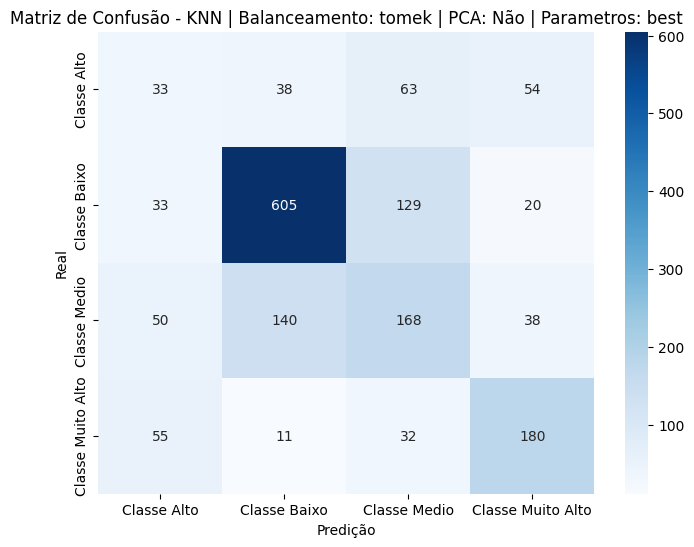


Relat√≥rio de Classifica√ß√£o para KNN | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.77       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.60      1649

Tempo de treinamento: 0.0063 segundos

==================== DecisionTree ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para DecisionTree, usando default.


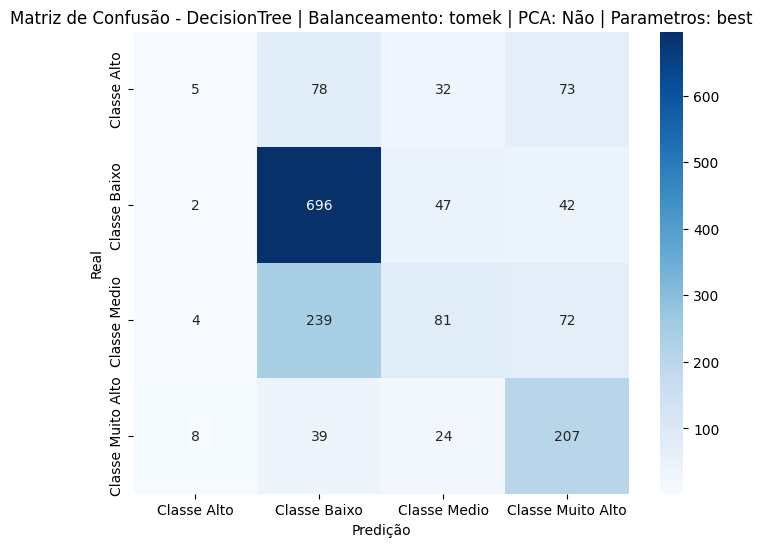


Relat√≥rio de Classifica√ß√£o para DecisionTree | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.53      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.47      0.43      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.2042 segundos

==================== NeuralNetwork ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para NeuralNetwork, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


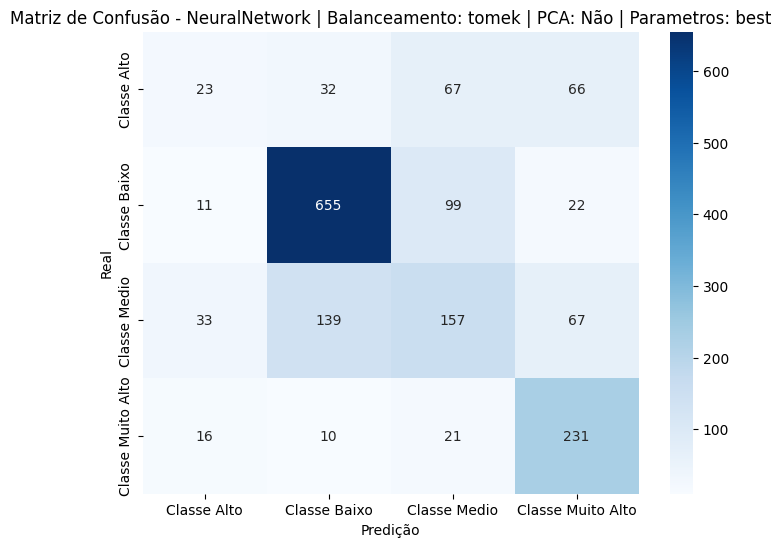


Relat√≥rio de Classifica√ß√£o para NeuralNetwork | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.28      0.12      0.17       188
     Classe Baixo       0.78      0.83      0.81       787
     Classe Medio       0.46      0.40      0.42       396
Classe Muito Alto       0.60      0.83      0.70       278

         accuracy                           0.65      1649
        macro avg       0.53      0.55      0.52      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 20.9481 segundos

==================== NaiveBayes ====================


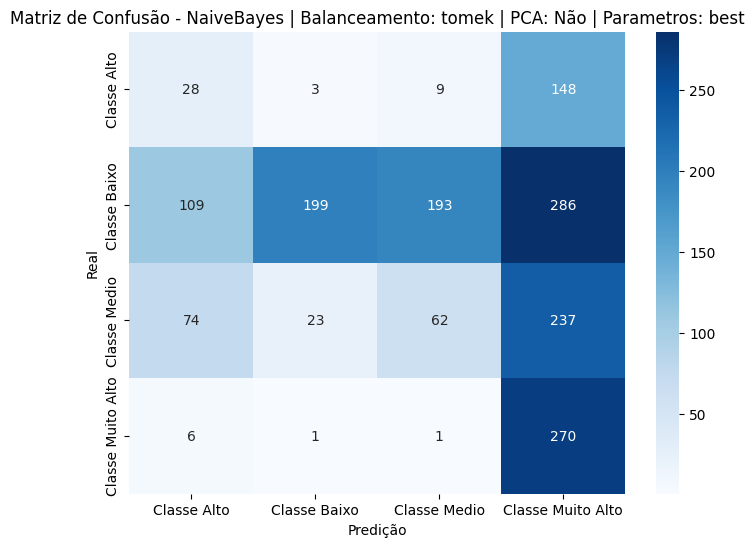


Relat√≥rio de Classifica√ß√£o para NaiveBayes | Balanceamento: tomek | PCA: N√£o | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0685 segundos


Modelo  Acur√°cia Teste  \
0  LogisticRegression | Balanceamento: tomek | PC...        0.651304   
5  NeuralNetwork | Balanceamento: tomek | PCA: N√£...        0.646452   
2  SVM | Balanceamento: tomek | PCA: N√£o | Parame...        0.642814   
4  DecisionTree | Balanceamento: tomek | PCA: N√£o...        0.599757   
3  KNN | Balanceamento: tomek | PCA: N√£o | Parame...        0.597938   
1  RandomForest | Balanceamento: tomek | PCA: N√£o...        0.524560   
6  NaiveBayes | Balanceamento: tomek | PCA: N√£o |...        0.338993   

   Tempo Treinamento (s) Melhores Par√¢metros  
0               9.626359                 N/A  
5              20.948091                 N/A  
2              14.410265                 N/A  
4               0.204195                 N/A  
3               0.006269                 N/A  
1               2.624723                 N/A  
6               0.068469                 N/A

‚ú® Melhor modelo salvo: LogisticRegression com acur√°cia de 0.6513!

==================== LogisticRegression ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para LogisticRegression, usando default.
‚ú® Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: best com acur√°cia de 0.6246!


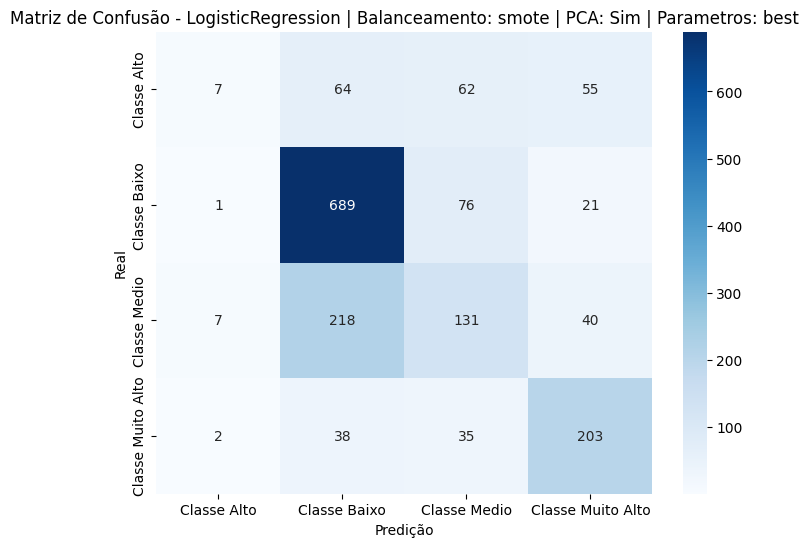


Relat√≥rio de Classifica√ß√£o para LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.04      0.07       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.64      0.73      0.68       278

         accuracy                           0.62      1649
        macro avg       0.54      0.49      0.47      1649
     weighted avg       0.58      0.62      0.58      1649

Tempo de treinamento: 5.1061 segundos

==================== RandomForest ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para RandomForest, usando default.
‚ú® Novo melhor modelo encontrado: RandomForest | Balanceamento: smote | PCA: Sim | Parametros: best com acur√°cia de 0.6398!


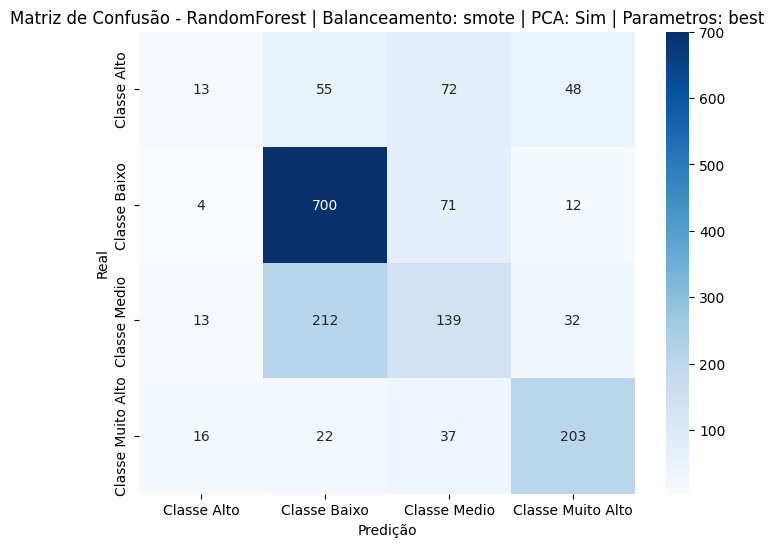


Relat√≥rio de Classifica√ß√£o para RandomForest | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.28      0.07      0.11       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.44      0.35      0.39       396
Classe Muito Alto       0.69      0.73      0.71       278

         accuracy                           0.64      1649
        macro avg       0.53      0.51      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 13.2459 segundos

==================== SVM ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para SVM, usando default.


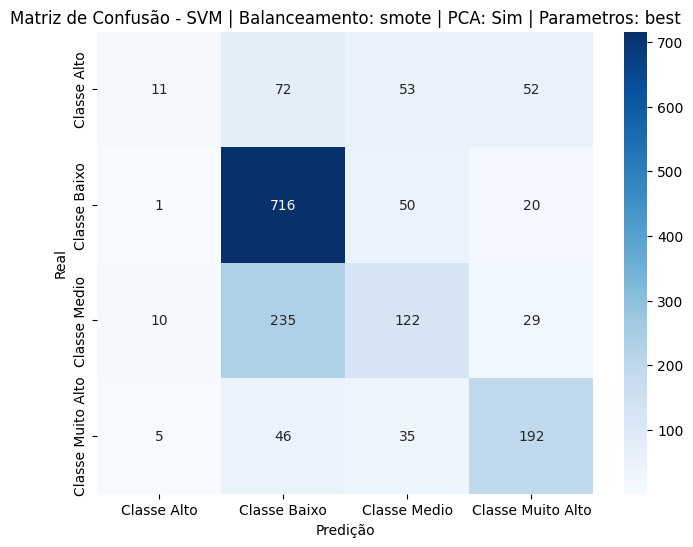


Relat√≥rio de Classifica√ß√£o para SVM | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.06      0.10       188
     Classe Baixo       0.67      0.91      0.77       787
     Classe Medio       0.47      0.31      0.37       396
Classe Muito Alto       0.66      0.69      0.67       278

         accuracy                           0.63      1649
        macro avg       0.55      0.49      0.48      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 2.7386 segundos

==================== KNN ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para KNN, usando default.


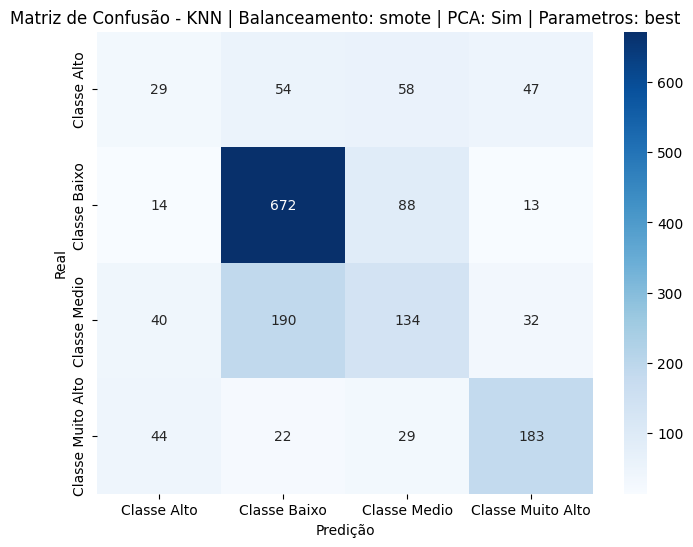


Relat√≥rio de Classifica√ß√£o para KNN | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.23      0.15      0.18       188
     Classe Baixo       0.72      0.85      0.78       787
     Classe Medio       0.43      0.34      0.38       396
Classe Muito Alto       0.67      0.66      0.66       278

         accuracy                           0.62      1649
        macro avg       0.51      0.50      0.50      1649
     weighted avg       0.58      0.62      0.60      1649

Tempo de treinamento: 0.0053 segundos

==================== DecisionTree ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para DecisionTree, usando default.


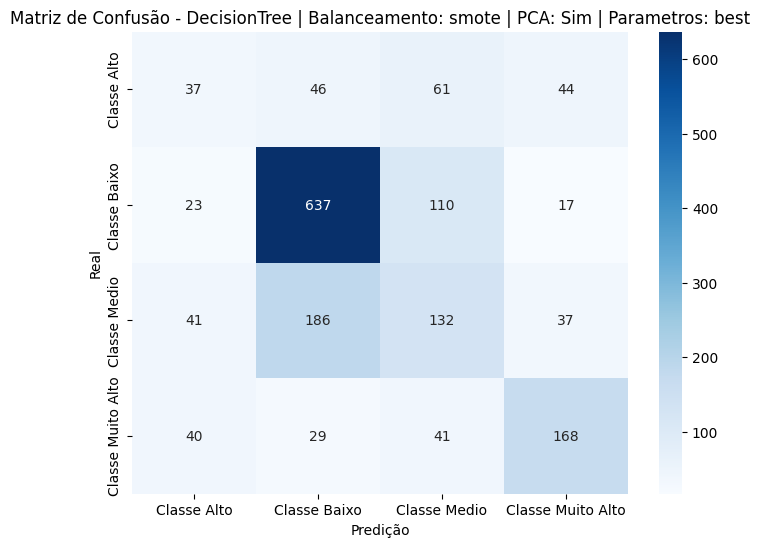


Relat√≥rio de Classifica√ß√£o para DecisionTree | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.20      0.22       188
     Classe Baixo       0.71      0.81      0.76       787
     Classe Medio       0.38      0.33      0.36       396
Classe Muito Alto       0.63      0.60      0.62       278

         accuracy                           0.59      1649
        macro avg       0.50      0.49      0.49      1649
     weighted avg       0.57      0.59      0.58      1649

Tempo de treinamento: 0.6514 segundos

==================== NeuralNetwork ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para NeuralNetwork, usando default.
‚ú® Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: best com acur√°cia de 0.6410!


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


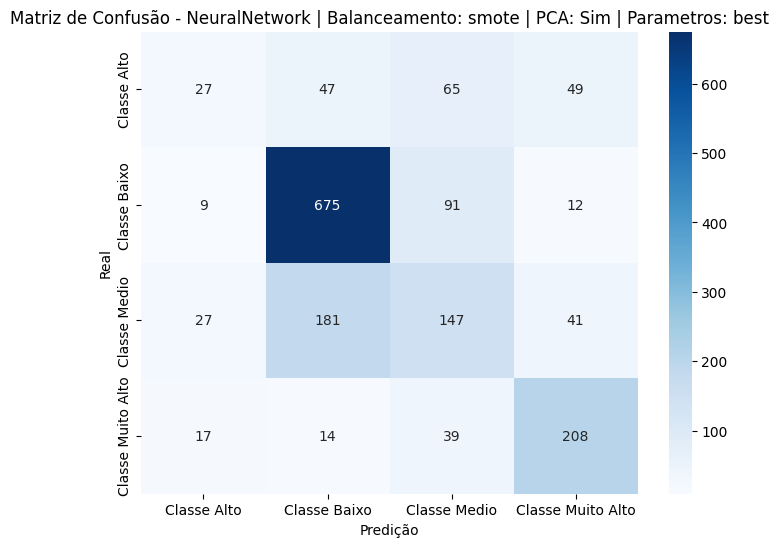


Relat√≥rio de Classifica√ß√£o para NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.34      0.14      0.20       188
     Classe Baixo       0.74      0.86      0.79       787
     Classe Medio       0.43      0.37      0.40       396
Classe Muito Alto       0.67      0.75      0.71       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.52      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 5.9671 segundos

==================== NaiveBayes ====================


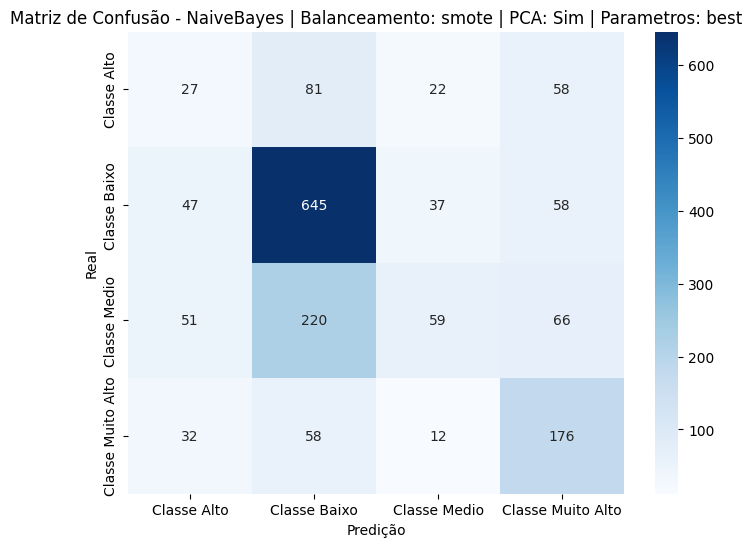


Relat√≥rio de Classifica√ß√£o para NaiveBayes | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.17      0.14      0.16       188
     Classe Baixo       0.64      0.82      0.72       787
     Classe Medio       0.45      0.15      0.22       396
Classe Muito Alto       0.49      0.63      0.55       278

         accuracy                           0.55      1649
        macro avg       0.44      0.44      0.41      1649
     weighted avg       0.52      0.55      0.51      1649

Tempo de treinamento: 0.0096 segundos


Modelo  Acur√°cia Teste  \
5  NeuralNetwork | Balanceamento: smote | PCA: Si...        0.640995   
1  RandomForest | Balanceamento: smote | PCA: Sim...        0.639782   
2  SVM | Balanceamento: smote | PCA: Sim | Parame...        0.631292   
0  LogisticRegression | Balanceamento: smote | PC...        0.624621   
3  KNN | Balanceamento: smote | PCA: Sim | Parame...        0.617344   
4  DecisionTree | Balanceamento: smote | PCA: Sim...        0.590661   
6  NaiveBayes | Balanceamento: smote | PCA: Sim |...        0.550030   

   Tempo Treinamento (s) Melhores Par√¢metros  
5               5.967108                 N/A  
1              13.245941                 N/A  
2               2.738595                 N/A  
0               5.106077                 N/A  
3               0.005347                 N/A  
4               0.651421                 N/A  
6               0.009566                 N/A

‚ú® Melhor modelo salvo: NeuralNetwork com acur√°cia de 0.6410!

==================== LogisticRegression ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para LogisticRegression, usando default.
‚ú® Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: best com acur√°cia de 0.6264!


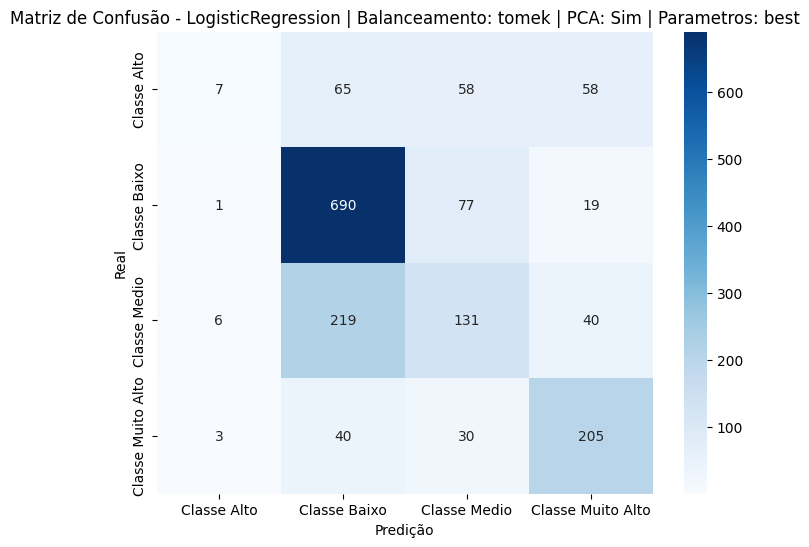


Relat√≥rio de Classifica√ß√£o para LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.04      0.07       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.44      0.33      0.38       396
Classe Muito Alto       0.64      0.74      0.68       278

         accuracy                           0.63      1649
        macro avg       0.54      0.50      0.47      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 4.9018 segundos

==================== RandomForest ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para RandomForest, usando default.
‚ú® Novo melhor modelo encontrado: RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: best com acur√°cia de 0.6404!


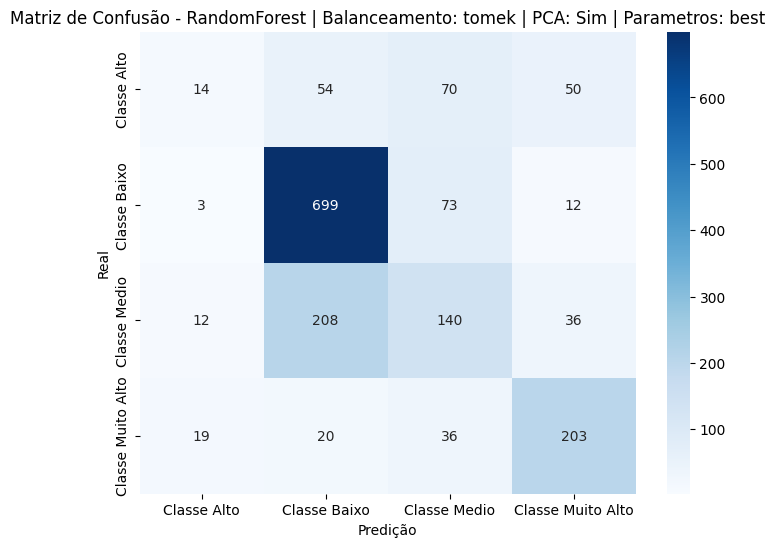


Relat√≥rio de Classifica√ß√£o para RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.29      0.07      0.12       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.44      0.35      0.39       396
Classe Muito Alto       0.67      0.73      0.70       278

         accuracy                           0.64      1649
        macro avg       0.53      0.51      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 13.1792 segundos

==================== SVM ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para SVM, usando default.


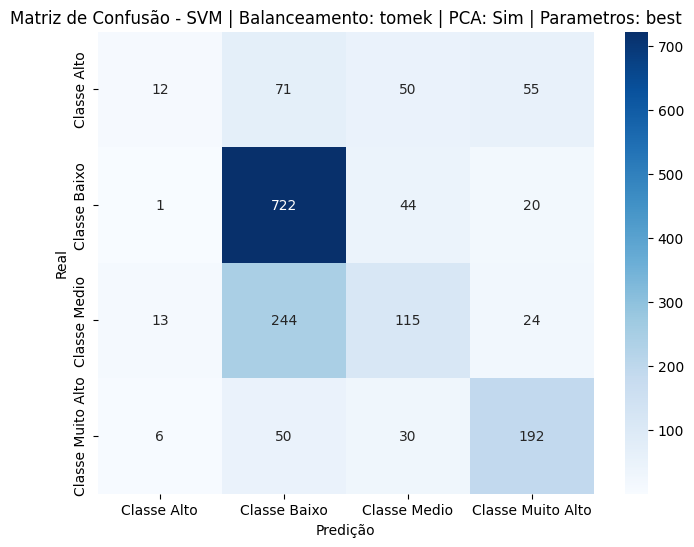


Relat√≥rio de Classifica√ß√£o para SVM | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.38      0.06      0.11       188
     Classe Baixo       0.66      0.92      0.77       787
     Classe Medio       0.48      0.29      0.36       396
Classe Muito Alto       0.66      0.69      0.67       278

         accuracy                           0.63      1649
        macro avg       0.55      0.49      0.48      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 2.8111 segundos

==================== KNN ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para KNN, usando default.


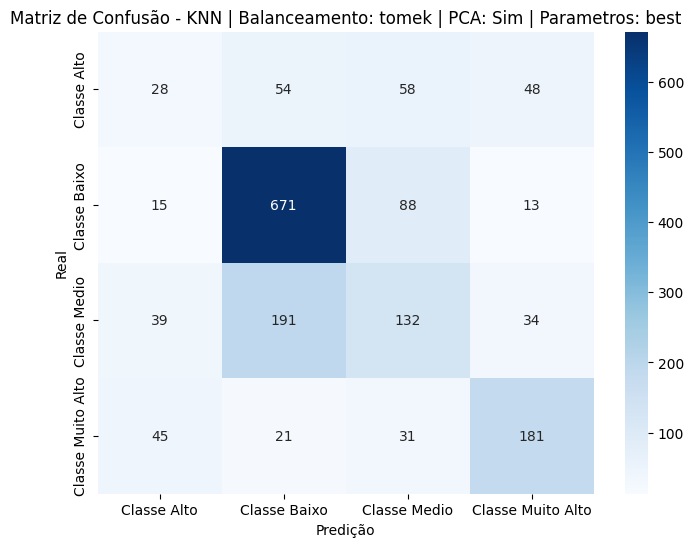


Relat√≥rio de Classifica√ß√£o para KNN | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.22      0.15      0.18       188
     Classe Baixo       0.72      0.85      0.78       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.66      0.65      0.65       278

         accuracy                           0.61      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.58      0.61      0.59      1649

Tempo de treinamento: 0.0060 segundos

==================== DecisionTree ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para DecisionTree, usando default.


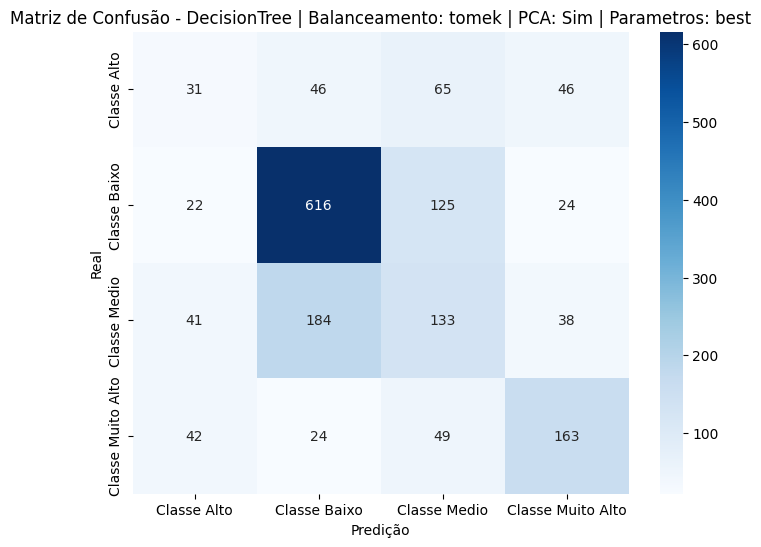


Relat√≥rio de Classifica√ß√£o para DecisionTree | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.23      0.16      0.19       188
     Classe Baixo       0.71      0.78      0.74       787
     Classe Medio       0.36      0.34      0.35       396
Classe Muito Alto       0.60      0.59      0.59       278

         accuracy                           0.57      1649
        macro avg       0.47      0.47      0.47      1649
     weighted avg       0.55      0.57      0.56      1649

Tempo de treinamento: 0.6540 segundos

==================== NeuralNetwork ====================
Aten√ß√£o ‚ö†Ô∏è: N√£o encontrei par√¢metros salvos para NeuralNetwork, usando default.
‚ú® Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: best com acur√°cia de 0.6410!


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


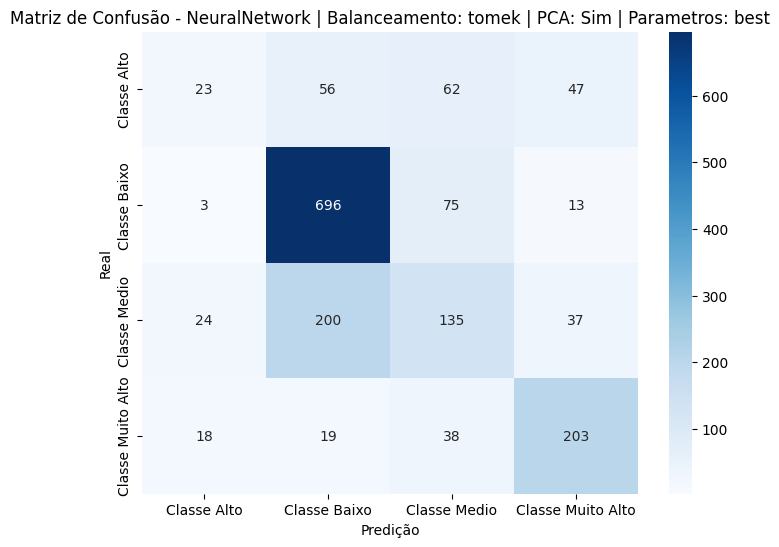


Relat√≥rio de Classifica√ß√£o para NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.34      0.12      0.18       188
     Classe Baixo       0.72      0.88      0.79       787
     Classe Medio       0.44      0.34      0.38       396
Classe Muito Alto       0.68      0.73      0.70       278

         accuracy                           0.64      1649
        macro avg       0.54      0.52      0.51      1649
     weighted avg       0.60      0.64      0.61      1649

Tempo de treinamento: 4.9105 segundos

==================== NaiveBayes ====================


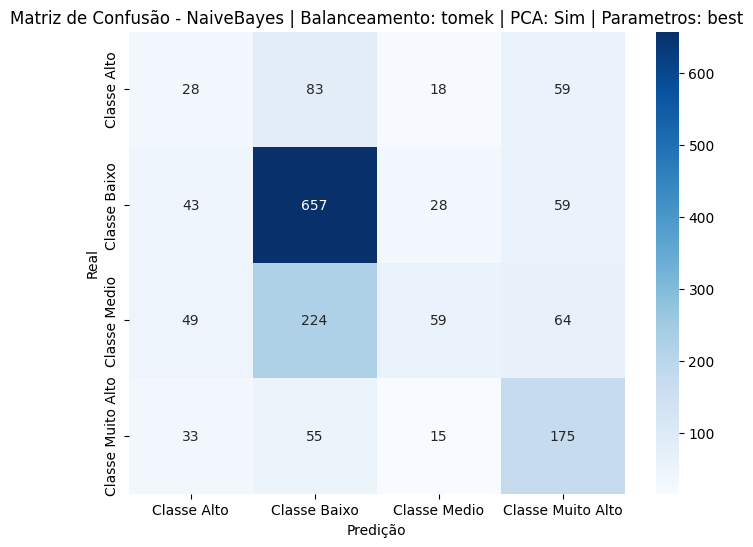


Relat√≥rio de Classifica√ß√£o para NaiveBayes | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.18      0.15      0.16       188
     Classe Baixo       0.64      0.83      0.73       787
     Classe Medio       0.49      0.15      0.23       396
Classe Muito Alto       0.49      0.63      0.55       278

         accuracy                           0.56      1649
        macro avg       0.45      0.44      0.42      1649
     weighted avg       0.53      0.56      0.51      1649

Tempo de treinamento: 0.0131 segundos


Modelo  Acur√°cia Teste  \
5  NeuralNetwork | Balanceamento: tomek | PCA: Si...        0.640995   
1  RandomForest | Balanceamento: tomek | PCA: Sim...        0.640388   
2  SVM | Balanceamento: tomek | PCA: Sim | Parame...        0.631292   
0  LogisticRegression | Balanceamento: tomek | PC...        0.626440   
3  KNN | Balanceamento: tomek | PCA: Sim | Parame...        0.613705   
4  DecisionTree | Balanceamento: tomek | PCA: Sim...        0.571862   
6  NaiveBayes | Balanceamento: tomek | PCA: Sim |...        0.557307   

   Tempo Treinamento (s) Melhores Par√¢metros  
5               4.910540                 N/A  
1              13.179198                 N/A  
2               2.811112                 N/A  
0               4.901773                 N/A  
3               0.006008                 N/A  
4               0.653975                 N/A  
6               0.013079                 N/A

‚ú® Melhor modelo salvo: NeuralNetwork com acur√°cia de 0.6410!
Evaluating scenario: best


AttributeError: 'tuple' object has no attribute 'fit'

In [52]:
# Example usage of the treinar_modelos function
scenarios = []

# # Best Parameters
scenarios.append(("best", treinar_modelos(tipo_parametros="best")))
scenarios.append(("best + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="best")))
scenarios.append(("best + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="best")))
scenarios.append(("best + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="best")))
scenarios.append(("best + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="best")))

# Iterate through scenarios and evaluate
for name, pipeline in scenarios:
    print(f"Evaluating scenario: {name}")
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"Score for {name}: {score}")

In [58]:
df_resultados_globais = pd.DataFrame(resultados_global)
df_resultados_globais.head()

df_resultados_globais.to_csv("resultados_globais.csv", index=False)

print("Arquivo 'resultados_globais.csv' salvo com sucesso!")

Arquivo 'resultados_globais.csv' salvo com sucesso!
